In [1]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

## 1. Problem Statement

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).
- build a classification model to predict if the client will subscribe to a term deposit 
- explain what kind of decisions you made and why when you go from raw data to the final model. 

Source: S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## 2. Data

#### 2.1 Feature List

| Variable  | Category | Type
| :------------ | :-------------- | :----- |
| age | Client Data | numeric |
| job | Client Data | categorical |
| marital | Client Data | categorical |
| education | Client Data | categorical |
| default | Client Data | categorical |
| housing | Client Data | categorical |
| loan | Client Data | categorical |
| contact | Campain Data | categorical |
| month | Campain Data | categorical |
| day_of_week | Campaign Data | categorical |
| ~duration~ | ~Campaign Data~ | ~numeric~ |
| campaign | Other Features | numeric |
| pdays | Other Features | numeric |
| previous | Other Features | numeric |
| poutcome | Other Features | categorical |
| emp.var.rate | Socioeconomics | numeric |
| cons.price.idx | Socioeconomics | numeric |
| euribor3m | Socioeconomics | numeric |
| poutcome | Socioeconomics | numeric |
| nr.employed | Socioeconomics | numeric |
| y | target | categorical |


#### Feature Description

### Input variables:
#### bank client data:
1 - age (numeric) \
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') \
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) \
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') \
5 - default: has credit in default? (categorical: 'no','yes','unknown') \
6 - housing: has housing loan? (categorical: 'no','yes','unknown') \
7 - loan: has personal loan? (categorical: 'no','yes','unknown') 
#### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone') \
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') \
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri') \
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. 
#### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) \
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) \
14 - previous: number of contacts performed before this campaign and for this client (numeric) \
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') 
#### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) \
17 - cons.price.idx: consumer price index - monthly indicator (numeric) \
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) \
19 - euribor3m: euribor 3 month rate - daily indicator (numeric) \
20 - nr.employed: number of employees - quarterly indicator (numeric) 

### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no') 

In [2]:
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import get_dummies
from scipy.stats import percentileofscore

In [3]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, \
    classification_report, average_precision_score, roc_auc_score
from xgboost import XGBClassifier

### Loading Data

In [4]:
glob.glob('data/*', recursive=True)

['data/bank-additional-full.csv',
 'data/bank-additional.csv',
 'data/bank-additional-names.txt']

In [5]:
data = pd.read_csv('data/bank-additional-full.csv', sep=';').drop(columns = ['duration'])

In [6]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 3. Features Evaluation

### 3.1 Overal View

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [8]:
data.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### 3.2 In depth analysis

#### Target Variable

In [9]:
data['y_numeric'] = data['y'].map({'yes':1, 'no':0})
positive_rate = round(data['y_numeric'].mean()*100,2)
print(f"Overal success rate of campaign is {positive_rate}%")

Overal success rate of campaign is 11.27%


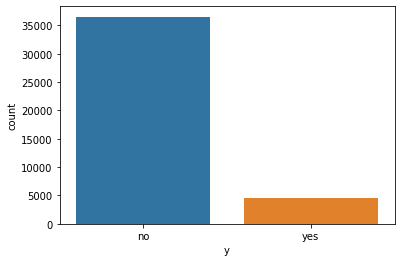

In [10]:
ax = sns.countplot(x="y",data=data)

#### Features

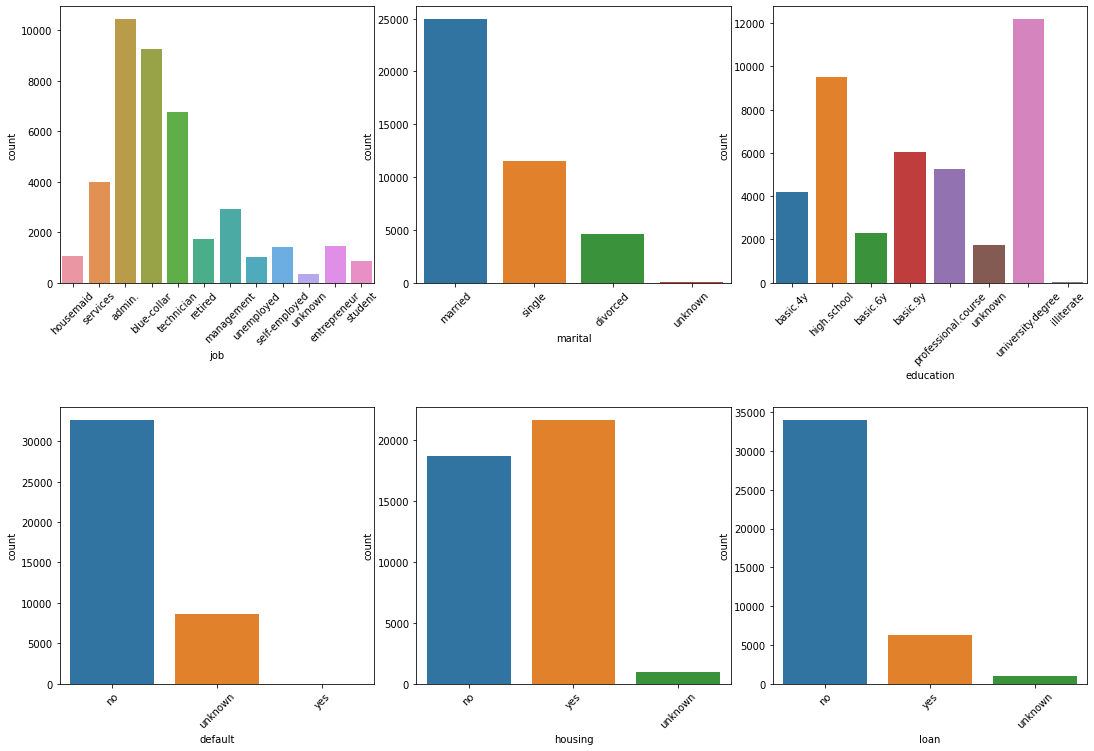

In [11]:
fig, axs = plt.subplots(2,3, figsize = [15,10])
fig.tight_layout() 
fig.subplots_adjust(hspace=.45)  
for i, feature in enumerate(['job', 'marital', 'education', 'default', 'housing', 'loan']):
    ax=axs[i//3,i%3]
    sns.countplot(x= data[feature], ax=ax)
    ax.tick_params(axis='x', rotation=45)


In [12]:
data_yes = data.query("y == 'yes'")
data_no = data.query("y == 'no'")
data_balance_sample = pd.concat([data_yes.sample(100000, replace=True), data_no.sample(100000, replace=True)], axis = 0).reset_index(drop=True)
#data_balance_sample.head()

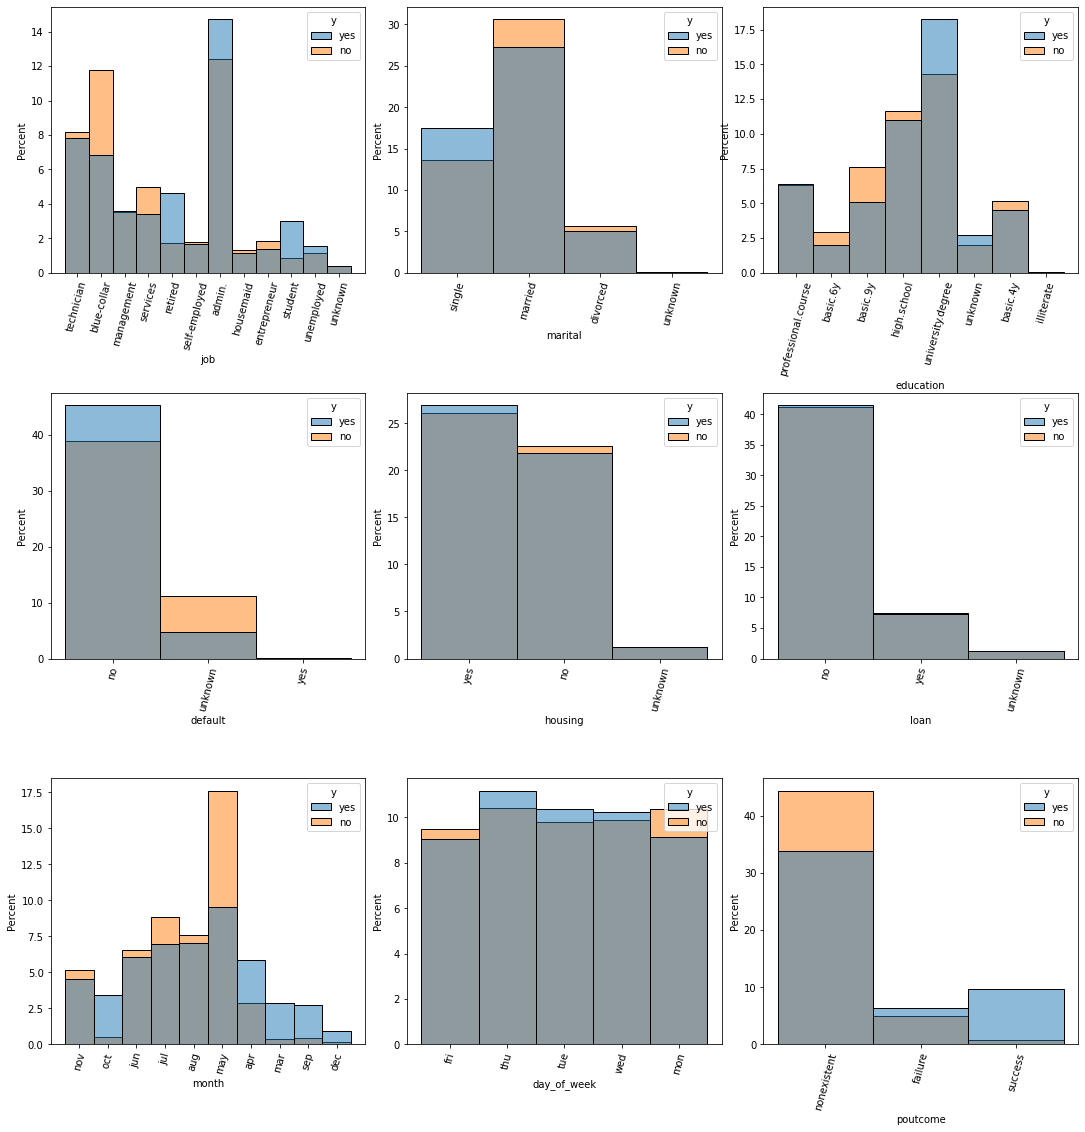

In [13]:
fig, axs = plt.subplots(3, 3, figsize = [15,15])
fig.tight_layout() 
fig.subplots_adjust(hspace=.45)  
for i, feature in enumerate(
    ['job', 'marital', 'education',
     'default', 'housing', 'loan',
     'month', 'day_of_week', 'poutcome']):
    ax=axs[i//3,i%3]
    sns.histplot(hue=data_balance_sample['y'], x= data_balance_sample[feature], stat='percent', ax=ax)
    ax.tick_params(axis='x', rotation=75)

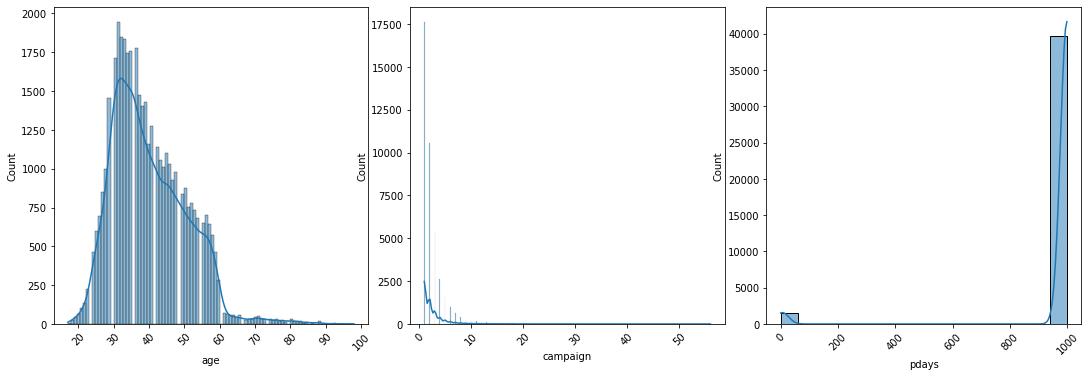

In [14]:
fig, axs = plt.subplots(1,3, figsize = [15,5])
fig.tight_layout() 
fig.subplots_adjust(hspace=.45)  
for i, feature in enumerate(['age','campaign', 'pdays']):
    ax=axs[i]
    sns.histplot(x= data[feature], ax=ax, kde = True)
    ax.tick_params(axis='x', rotation=45)

In [15]:
# Seems we have to impute the value or drop this variable
data['pdays'].apply(lambda x: 'None' if x==999 else 'Positive').value_counts()/len(data)*100

None        96.321744
Positive     3.678256
Name: pdays, dtype: float64

<AxesSubplot:xlabel='pdays', ylabel='Count'>

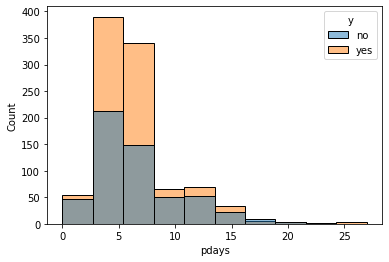

In [16]:
sns.histplot(x=data.query("pdays!=999")['pdays'], hue=data.query("pdays!=999")['y'], bins=10)

In [17]:
perc99 = round(data.query("campaign<=14")['campaign'].count()/len(data)*100,1)
print(f"Number of data point with campaign being less than or eqial to 14 is {perc99}%")

Number of data point with campaign being less than or eqial to 14 is 99.0%


It seems better to winsorize campaign variable, which means:
- campaign = 14 if campaign > 14

<AxesSubplot:>

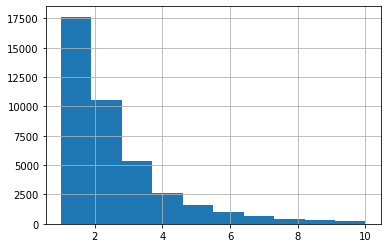

In [18]:
data.query("campaign<=10")['campaign'].hist()

<AxesSubplot:>

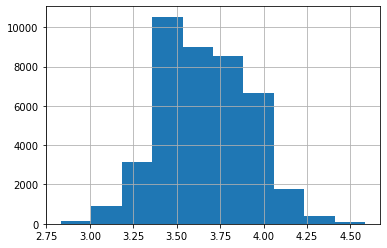

In [19]:
# age is also less skewed if log-transformed
np.log(data['age']).hist()

## Feature Engineering

#### Categorical Features

In [20]:
def process_dummies(df):
    """Get a dataframe and convert all columns to dummy variables with proper names"""
    df_out = pd.DataFrame({})
    for col in df.columns:
        dummied = get_dummies(df[col], drop_first = True)
        dummied.columns = [f"{col}_{dcol}" for dcol in dummied.columns]
        if len(df_out) == 0:
            df_out = dummied
        else:
            df_out = pd.concat([df_out, dummied], axis = 1)
    return df_out

In [21]:
categorical_features = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan','month', 'day_of_week', 'poutcome'
]

In [22]:
data_categorical_processed = process_dummies(data[categorical_features])
data_categorical_processed.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


#### Numerical Features

In [23]:
numerical_features = [
    'age','campaign', 'emp.var.rate',
    'cons.price.idx', 'euribor3m', 'nr.employed'
]

In [24]:
data_numeric = data[numerical_features].copy()

<AxesSubplot:>

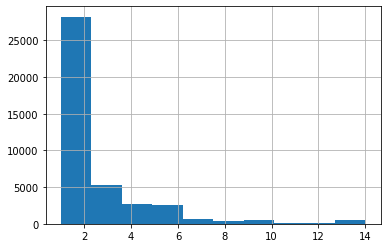

In [25]:
## fix campaign
data_numeric['campaign'] = data_numeric['campaign'].apply(lambda x: 14 if x > 14 else x)
data_numeric['campaign'].hist()

In [26]:
## transform age
data_numeric['age_log'] = np.log(data_numeric['age'])
data_numeric = data_numeric.drop(columns = ['age'])

In [27]:
numerical_features.remove('age')
numerical_features.append('age_log')
numerical_features

['campaign',
 'emp.var.rate',
 'cons.price.idx',
 'euribor3m',
 'nr.employed',
 'age_log']

In [28]:
def process_numeric(df, col: str = None):
    """Scale numerical dara to [0,1] interval"""
    df_out = df.copy()
    if col:
        return df_out[col].transform(lambda x: (x - x.min())/(x.max() - x.min()))
    else:
        for col in df.columns:
            df_out[col] = process_numeric(df, col)
    return df_out

In [29]:
data_numeric_processed = process_numeric(data_numeric)
data_numeric_processed.head()

,campaign,emp.var.rate,cons.price.idx,euribor3m,nr.employed,age_log
0,0.0,0.9375,0.698753,0.957379,0.859735,0.680540
1,0.0,0.9375,0.698753,0.957379,0.859735,0.690644
2,0.0,0.9375,0.698753,0.957379,0.859735,0.443958
3,0.0,0.9375,0.698753,0.957379,0.859735,0.488462
4,0.0,0.9375,0.698753,0.957379,0.859735,0.680540


In [30]:
features = pd.concat([data_numeric_processed, data_categorical_processed], axis = 1)

In [31]:
features.head()

,campaign,emp.var.rate,cons.price.idx,euribor3m,nr.employed,age_log,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.0,0.9375,0.698753,0.957379,0.859735,0.680540,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
1,0.0,0.9375,0.698753,0.957379,0.859735,0.690644,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0.0,0.9375,0.698753,0.957379,0.859735,0.443958,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0.0,0.9375,0.698753,0.957379,0.859735,0.488462,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0.0,0.9375,0.698753,0.957379,0.859735,0.680540,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, data['y_numeric'], test_size=.25, shuffle=True, stratify=data['y_numeric'])

### Modeling

In [33]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

##### Logistic Regression with imbalanced data

In [34]:
LRCls = LogisticRegressionCV(max_iter = 3000) #default is 5 fold

In [35]:
LRCls.fit(x_train, y_train)

LogisticRegressionCV(max_iter=3000)

In [36]:
print((
    f"Insample model score is {round(LRCls.score(x_train, y_train)*100,1)}"
    f" and outsample score is {round(LRCls.score(x_test, y_test)*100,1)}"
))

Insample model score is 90.0 and outsample score is 90.0


In [37]:
y_pred = LRCls.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[9025,  112],
       [ 917,  243]])

In [38]:
probas_ = LRCls.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7930960418608688

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9137
           1       0.68      0.21      0.32      1160

    accuracy                           0.90     10297
   macro avg       0.80      0.60      0.63     10297
weighted avg       0.88      0.90      0.88     10297



##### Logistic Regression with imbalanced data and balanced weights

In [40]:
LRCls = LogisticRegressionCV(max_iter = 3000, class_weight='balanced')

In [41]:
LRCls.fit(x_train, y_train)

LogisticRegressionCV(class_weight='balanced', max_iter=3000)

In [42]:
print((
    f"Insample model score is {round(LRCls.score(x_train, y_train)*100,1)}"
    f" and outsample score is {round(LRCls.score(x_test, y_test)*100,1)}"
))

Insample model score is 83.1 and outsample score is 83.5


In [43]:
y_pred = LRCls.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[7878, 1259],
       [ 441,  719]])

In [44]:
probas_ = LRCls.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7936569480664066

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      9137
           1       0.36      0.62      0.46      1160

    accuracy                           0.83     10297
   macro avg       0.66      0.74      0.68     10297
weighted avg       0.88      0.83      0.85     10297



<AxesSubplot:>

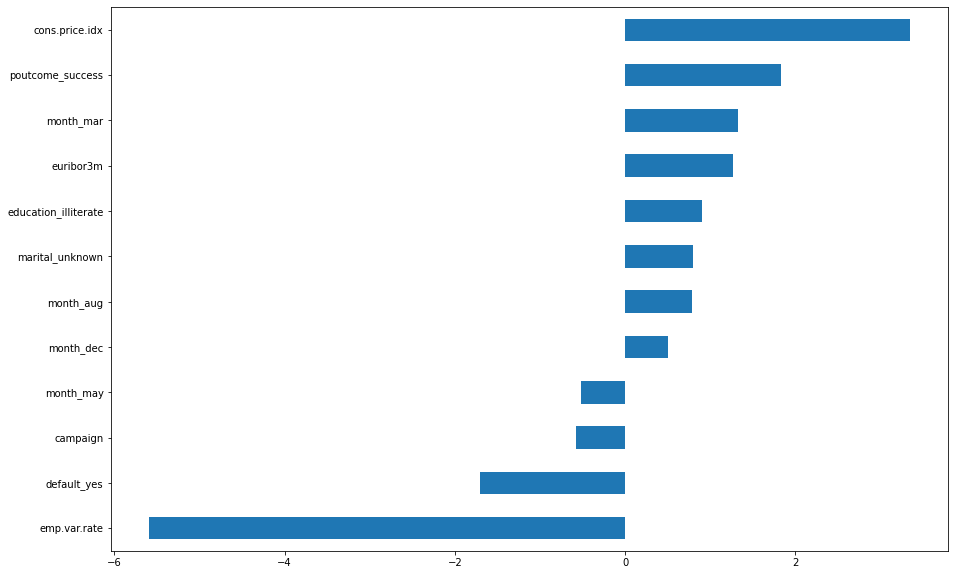

In [93]:
importance = LRCls.coef_[0]
importance_df = pd.DataFrame(data=importance.tolist(), index=x_train.columns.tolist(), columns=['feature_importance'])
importance_df['abs_importance'] = np.abs(importance_df['feature_importance'])
median_importance = importance_df['abs_importance'].mean()
fig, ax = plt.subplots(1,1, figsize = [15,10])
importance_df\
    .query('abs_importance>=@median_importance')\
    .sort_values('feature_importance', ascending=True)['feature_importance']\
    .plot(kind='barh', ax=ax)

##### Plain XGBoost

In [46]:
XGBCls = XGBClassifier(eval_metric='logloss', use_label_encoder=False) #, scale_pos_weight = 5)
XGBCls.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [47]:
print((
    f"Insample model score is {round(XGBCls.score(x_train, y_train)*100,1)}"
    f" and outsample score is {round(XGBCls.score(x_test, y_test)*100,1)}"
))

Insample model score is 92.8 and outsample score is 89.9


In [48]:
y_pred = XGBCls.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[8925,  212],
       [ 830,  330]])

In [49]:
probas_ = XGBCls.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7907024017541409

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9137
           1       0.61      0.28      0.39      1160

    accuracy                           0.90     10297
   macro avg       0.76      0.63      0.67     10297
weighted avg       0.88      0.90      0.88     10297

